# Netflix Movie Recommendation System

<p>
Netflix's competition to improve their reccommendation algorithm

Netflix held the Netflix Prize open competition for the best algorithm to predict user ratings for films. The grand prize was $1,000,000 and was won by BellKor's Pragmatic Chaos team. This is the dataset that was used in that competition.

https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data
</p>

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

%matplotlib inline

In [2]:
# Merging data into a single file

rows = list()
files = ['data/combined_data_1.txt',
         'data/combined_data_2.txt',
         'data/combined_data_3.txt',
         'data/combined_data_4.txt']

for file in files:
    print(f"Reading data from: {file}")
    with open(file, 'r') as f:
        movie_id = None
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                movie_id = line.replace(':', '')
            else:
                user_id, rating, date = line.split(',')
                rows.append([movie_id, user_id, rating, date])
    print("Done.\n")

Reading data from: data/combined_data_1.txt
Done.

Reading data from: data/combined_data_2.txt
Done.

Reading data from: data/combined_data_3.txt
Done.

Reading data from: data/combined_data_4.txt
Done.



In [3]:
# Create DataFrame
df = pd.DataFrame(rows, columns=['movie', 'user', 'rating', 'date'])
df.date = pd.to_datetime(df.date)

# sort data by date field
df.sort_values(by='date', inplace=True)

df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


## Exploratory Data Analysis

#### Dataset Memory Optimization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 56431994 to 25464092
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   movie   object        
 1   user    object        
 2   rating  object        
 3   date    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 3.7+ GB


In [5]:
# Convert data types
for col in ['movie','user','rating']:
    df[col] = df[col].astype('int64')

In [6]:
def reduce_mem_usage(df, verbose=True):
     
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in ['movie', 'user','rating']:

        c_min = df[col].min()
        c_max = df[col].max()
             
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
df = reduce_mem_usage(df)

Mem. usage decreased to 2203.99 Mb (42.5% reduction)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 56431994 to 25464092
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   movie   int16         
 1   user    int32         
 2   rating  int8          
 3   date    datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(1), int8(1)
memory usage: 2.2 GB


In [9]:
# size of dataframe
df.shape

(100480507, 4)

In [10]:
# Check for NaN values
print(f"Number of Nan Values:{sum(df.isnull().any())}")

Number of Nan Values:0


In [11]:
# Check of duplicate records
print(f"Number of Duplicates records:{df.duplicated().sum()}")

Number of Duplicates records:0


In [12]:
df.describe()

,movie,user,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


In [13]:
print("Total no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))
print("Total No of ratings per user :", df.groupby('user')['rating'].count().describe())
print("Total No of ratings per movie :", df.groupby('movie')['rating'].count().describe())

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770
Total No of ratings per user : count    480189.000000
mean        209.251997
std         302.339155
min           1.000000
25%          39.000000
50%          96.000000
75%         259.000000
max       17653.000000
Name: rating, dtype: float64
Total No of ratings per movie : count     17770.000000
mean       5654.502364
std       16909.673269
min           3.000000
25%         192.000000
50%         561.000000
75%        2667.750000
max      232944.000000
Name: rating, dtype: float64


Distribution of ratings:


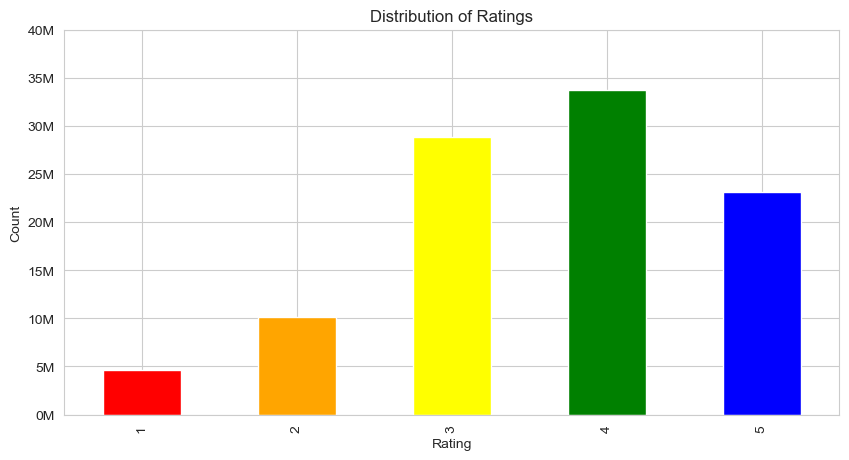

In [14]:
print("Distribution of ratings:")
df.rating.value_counts().sort_index().plot(kind='bar', figsize=(10, 5), color = ['red', 'orange', 'yellow', 'green', 'blue'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
# Format y-axis ticks to millions
yticks = plt.yticks()[0]   # Get current y-tick
plt.yticks(yticks, [f'{int(y/1e6)}M' for y in yticks])
plt.show()

**Observation:**

1. 1 star ratings are the least frequent (under 5 million).
2. 4 and 3 star ratings seem to be the most common.

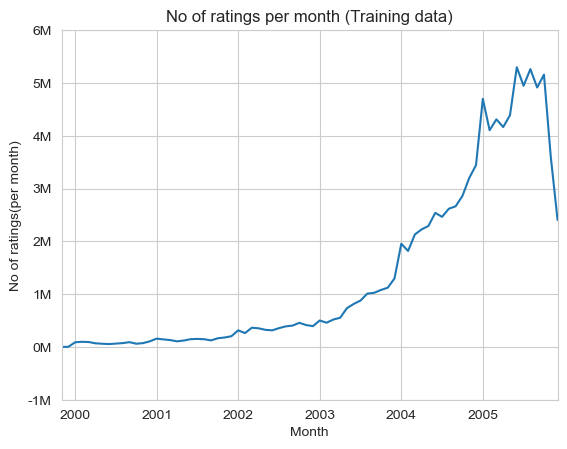

In [15]:
ax = df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
yticks = plt.yticks()[0]
plt.yticks(yticks, [f'{int(y/1e6)}M' for y in yticks])
plt.show()

**Observation:**

The trend reflects the growing popularity and user engagement with Netflix's platform during the early 2000s. The dataset likely ends before 2006, causing the sudden drop at the end.

Text(0.5, 1.0, 'PDF')

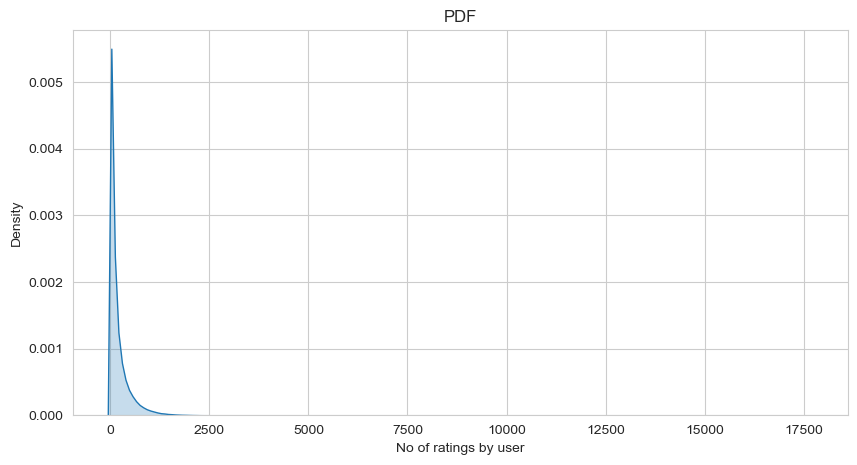

In [16]:
number_of_rating_per_user = df.groupby(by='user')['rating'].count().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.kdeplot(number_of_rating_per_user, fill=True)
plt.xlabel('No of ratings by user')
plt.title("PDF")

**Observation:**

The distribution is heavily right skewed with 25% of the users rating more than 259 times.

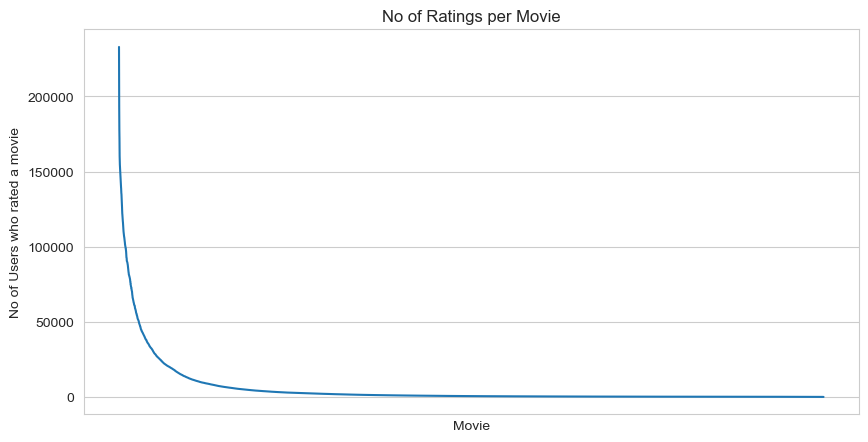

In [17]:
no_of_ratings_per_movie = df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(10, 5))
plt.plot(no_of_ratings_per_movie.values)
plt.title('No of Ratings per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
plt.xticks([])
plt.show()

**Observation:**

1. Around 25% of the movies have been rated more than 2667 times.
2. The maximum number of ratings a movie has recieved is 232944.
3. A movie has revieved atleast 3 ratings.

### Split data in train & test

In [18]:
# 80% of the data will be used for training and 20% for testing
split = int(df.shape[0]*0.80)

train_df = df.iloc[:split] 
test_df = df.iloc[split:] 

In [19]:
print("Training data ")
print("-"*50)
print("Total no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------
Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


In [20]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


In [21]:
# Create sparse matrix for training data
train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)

sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)

print('Shape of the Sparse Matrix for Train data: ',train_sparse_matrix.shape)

Shape of the Sparse Matrix for Train data:  (2649430, 17771)


In [22]:
# Create sparse matrix for test data
test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)),)

sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)

print('Shape of the Sparse Matrix for Test data: ',test_sparse_matrix.shape)

Shape of the Sparse Matrix for Test data:  (2649430, 17771)


In [ ]:
# Get top 10k users that have cummulatively rated all the movies
# top_10k_users = train_df.groupby('user')['rating'].count().sort_values(ascending=False).head(10000).index.tolist()
# top_10k_movies = train_df.groupby('movie')['rating'].count().sort_values(ascending=False).head(10000).index.tolist()
# top_10k_users = train_df[train_df['user'].isin(top_10k_users)]['user'].unique()
# top_10k_movies = train_df[train_df['movie'].isin(top_10k_movies)]['movie'].unique()


In [23]:
train_sparse_matrix.shape 

(2649430, 17771)

#### Observation:

We are sampling a small subset of data from the sparse matrices as the time needed to compute user-user similarity is high and would need days to run on my desktop. This might affect the model performance.  

In [24]:
# Create a function to compute movie similarity using cosine similarity 
def get_sample_sparse_matrix(sparse_matrix, num_users, num_movies, path, verbose=True):
    """
    Generated from ChatGPT:
    Samples a subset of the sparse_matrix with given number of users and movies,
    saves it to disk if not already present, and returns the sampled matrix.
    """
    row_ind, col_ind, data = sparse.find(sparse_matrix)
    
    if verbose:
        print(f"Original Matrix: Users = {sparse_matrix.shape[0]}, Movies = {sparse_matrix.shape[1]}")
        print(f"Total Ratings: {len(data)}\n")

    # Ensure reproducibility
    np.random.seed(15)

    # Sample user and movie indices
    sampled_users = np.random.choice(np.unique(row_ind), num_users, replace=False)
    sampled_movies = np.random.choice(np.unique(col_ind), num_movies, replace=False)

    # Create mask to filter the data
    mask = np.isin(row_ind, sampled_users) & np.isin(col_ind, sampled_movies)

    # Remap user/movie indices to 0-based dense matrix
    user_map = {user: i for i, user in enumerate(sorted(sampled_users))}
    movie_map = {movie: j for j, movie in enumerate(sorted(sampled_movies))}

    remapped_rows = np.array([user_map[u] for u in row_ind[mask]])
    remapped_cols = np.array([movie_map[m] for m in col_ind[mask]])
    sampled_data = data[mask]

    # Build sparse matrix
    sampled_matrix = sparse.csr_matrix((sampled_data, (remapped_rows, remapped_cols)),
                                       shape=(num_users, num_movies))

    sparse.save_npz(path, sampled_matrix)
    
    if verbose:
        print(f"Sampled Matrix: Users = {num_users}, Movies = {num_movies}")
        print(f"Sampled Ratings: {len(sampled_data)}")
        print("Saved to disk.\n")

    return sampled_matrix


In [42]:
path = "data/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("File Available")
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("Loaded...")
else:
    # get 10k users and 1k movies from the train sparse matrix
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, num_users=10000, num_movies=5000,
                                             path = path)
    
sample_train_sparse_matrix.shape 

Original Matrix: Users = 2649430, Movies = 17771
Total Ratings: 80384405

Sampled Matrix: Users = 10000, Movies = 5000
Sampled Ratings: 584337
Saved to disk.



(10000, 5000)

In [43]:
path = "data/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("File Available")
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("Loaded...")
else:
    # get 5k users and 500 movies from the test sparse matrix 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, num_users=5000, num_movies=500,
                                             path = path)

sample_test_sparse_matrix.shape 

Original Matrix: Users = 2649430, Movies = 17771
Total Ratings: 20096102

Sampled Matrix: Users = 5000, Movies = 500
Sampled Ratings: 7333
Saved to disk.



(5000, 500)

### Calculation the average ratings of all the reviews for imputation.

In [44]:
sample_train_averages = dict()

# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average

sample_train_averages 

{'global': 3.590777239846185}

In [45]:
# Find average rating for each user and movie in the sampled train set
user_averages = sample_train_sparse_matrix.mean(axis=1).A1
movie_averages = sample_train_sparse_matrix.mean(axis=0).A1
sample_train_averages['user'] = user_averages
sample_train_averages['movie'] = movie_averages
sample_train_averages['user'][:10], sample_train_averages['movie'][:10]

(array([0.004 , 0.0368, 0.0536, 0.0082, 0.0128, 0.0208, 0.0716, 0.004 ,
        0.0054, 0.0158]),
 array([8.200e-03, 2.600e-03, 2.800e-03, 2.400e-03, 1.630e-02, 3.000e-04,
        5.200e-03, 9.277e-01, 5.000e-03, 4.870e-02]))

In [46]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 584337


 No of ratings in Our Sampled test  matrix is : 7333



In [47]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

##### Combining user-user and movie-movie collaborative filtering from the sample sparse matrix to create new features like,  global average rating, ratings from top 5 similar user, ratings of the top 5 similar movies, average rating of the user, average rating of the movie.


In [48]:
start = datetime.now()
if os.path.isfile('data/reg_train.csv'):
    print("File exists")
else:
    print(f"Preparing {len(sample_train_ratings)} tuples for the dataset..\n")
    with open('data/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):


            # compute the similar Users of the "user"
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))


            # compute the similar movies of the "movie"
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))

            # Now we have 5 ratings of similar users for this movie and 5 ratings of similar movies rated by this user.
            # We will create a row of features for this user-movie pair.
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))

print(datetime.now() - start)

Preparing 584337 tuples for the dataset..

Done for 10000 rows----- 0:03:54.652786
Done for 20000 rows----- 0:07:45.214962
Done for 30000 rows----- 0:11:37.319098
Done for 40000 rows----- 0:15:33.820977
Done for 50000 rows----- 0:19:25.543669
Done for 60000 rows----- 0:23:18.445844
Done for 70000 rows----- 0:27:14.740338
Done for 80000 rows----- 0:31:07.347077
Done for 90000 rows----- 0:35:02.436676
Done for 100000 rows----- 0:38:58.668143
Done for 110000 rows----- 0:42:49.147544
Done for 120000 rows----- 0:46:45.617455
Done for 130000 rows----- 0:50:40.300914
Done for 140000 rows----- 0:54:31.340947
Done for 150000 rows----- 0:58:27.117297
Done for 160000 rows----- 1:02:22.250037
Done for 170000 rows----- 1:06:15.966512
Done for 180000 rows----- 1:10:12.966336
Done for 190000 rows----- 1:14:07.827514
Done for 200000 rows----- 1:18:13.302233
Done for 210000 rows----- 1:22:26.830927
Done for 220000 rows----- 1:26:26.032555
Done for 230000 rows----- 1:30:17.448718
Done for 240000 rows---

**Observation:** The time time taken to compute similarty matices for 10k users and 5k movies is around 4 hours.

In [49]:
reg_train = pd.read_csv('data/reg_train.csv', names = ['user', 'movie', 'global_avg', 'similar_user1', 'similar_user2', 'similar_user3', 'similar_user4', 'similar_user5','similar_movie_rating1', 'similar_movie_rating2', 'similar_movie_rating3', 'similar_movie_rating4', 'similar_movie_rating5', 'user_avg', 'movie_avg', 'rating'], header=None)
reg_train.head()

,user,movie,global_avg,similar_user1,similar_user2,similar_user3,similar_user4,similar_user5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_avg,movie_avg,rating
0,1971,0,3.590777,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,0.0604,0.0082,3
1,2334,0,3.590777,5.0,5.0,3.0,5.0,5.0,5.0,4.0,3.0,4.0,5.0,0.0456,0.0082,5
2,2793,0,3.590777,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0248,0.0082,5
3,2832,0,3.590777,1.0,5.0,5.0,3.0,5.0,4.0,3.0,4.0,3.0,4.0,0.2026,0.0082,5
4,3035,0,3.590777,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0092,0.0082,5


In [50]:
reg_train.shape

(584337, 16)

The train dataset has 584337 rows and 16 features.

In [51]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [52]:
# get users, movies and ratings from our samples test sparse matrix
if os.path.isfile('data/reg_test.csv'):
    print("File exists")
else:
    start = datetime.now()
    print(f"Preparing {len(sample_test_ratings)} tuples for the dataset..\n")
    with open('data/reg_test.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):


            try:
                # compute the similar Users of the "user"
                user_sim = cosine_similarity(sample_test_sparse_matrix[user], sample_test_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_test_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"
                movie_sim = cosine_similarity(sample_test_sparse_matrix[:,movie].T, sample_test_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_test_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)

Preparing 7333 tuples for the dataset..

Done for 1000 rows----- 0:00:01.444599
Done for 2000 rows----- 0:00:02.877940
Done for 3000 rows----- 0:00:04.344610
Done for 4000 rows----- 0:00:05.827937
Done for 5000 rows----- 0:00:07.277975
Done for 6000 rows----- 0:00:08.744875
Done for 7000 rows----- 0:00:10.177929
 0:00:10.661312


In [53]:
# cleanup unused variables
del sample_test_sparse_matrix
del sample_train_sparse_matrix

import gc
gc.collect()

4563

In [54]:
reg_test = pd.read_csv('data/reg_test.csv', names = ['user', 'movie', 'global_avg', 'similar_user1', 'similar_user2', 'similar_user3', 'similar_user4', 'similar_user5','similar_movie_rating1', 'similar_movie_rating2', 'similar_movie_rating3', 'similar_movie_rating4', 'similar_movie_rating5', 'user_avg', 'movie_avg', 'rating'], header=None)
reg_test.head()

,user,movie,global_avg,similar_user1,similar_user2,similar_user3,similar_user4,similar_user5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_avg,movie_avg,rating
0,1519,0,3.590777,4.0,5.0,4.0,0.0082,0.0082,0.0018,0.0018,0.0018,0.0018,0.0018,0.0018,0.0082,5
1,1791,0,3.590777,4.0,5.0,4.0,0.0082,0.0082,0.0510,0.0510,0.0510,0.0510,0.0510,0.0510,0.0082,4
2,3338,0,3.590777,4.0,5.0,4.0,0.0082,0.0082,0.0264,0.0264,0.0264,0.0264,0.0264,0.0264,0.0082,3
3,3568,0,3.590777,4.0,5.0,4.0,0.0082,0.0082,0.0374,0.0374,0.0374,0.0374,0.0374,0.0374,0.0082,4
4,57,1,3.590777,2.0,4.0,4.0,1.0000,3.0000,4.0000,0.0062,0.0062,0.0062,0.0062,0.0062,0.0026,1


In [55]:
reg_test.shape

(7333, 16)

#### Machine Learning Models.

#### Considering the problem as a regression problem to calculate the ratinga given by the user for a movie.

In [57]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test.drop(['user','movie','rating'], axis=1)
y_test = reg_test['rating']

#### Xgboost Regressor

Hyperparameter tuning to get best fit parameters.

In [ ]:
# train xgb regressor with grid search hyperparameter tuning


# Define the parameter grid
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [200, 400, 600],
    'reg_alpha': [0, 0.01, 0.1, 1],     
    'reg_lambda': [0, 0.01, 0.1, 1] 
}

# Create the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=-1)
# Fit the model
grid_search.fit(x_train, y_train)
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


c:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
11 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\Use

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 1, 'reg_lambda': 1}
Best Score: -0.7760927301203798


Train Data Eval                                   
Train Mean Squared Error: 0.7552013910868418
Train Mean Absolute Percentage Error: 0.25868122369470514
Train R^2 Score: 0.346583376370838
####################################################################################################
Test Data Eval                                    
Mean Squared Error: 4.947256715269392
Mean Absolute Percentage Error: 0.6100859280189657
R^2 Score: -3.279730753839872


<Figure size 1000x600 with 0 Axes>

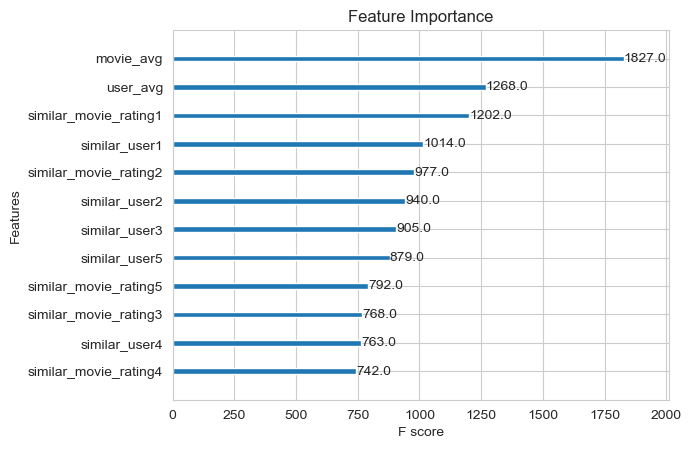

In [59]:
# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(x_train, y_train)

# Evaluate the model on the train data
y_train_pred = best_model.predict(x_train)

mse_train = mean_squared_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print("Train Data Eval".ljust(50, ' '))
print(f"Train Mean Squared Error: {mse_train}")
print(f"Train Mean Absolute Percentage Error: {mape_train}")
print(f"Train R^2 Score: {r2_train}")

# Evaluate the model on the test data
y_test_pred = best_model.predict(x_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred) 
print("#"*100)  
print("Test Data Eval".ljust(50, ' '))
print(f"Mean Squared Error: {mse_test}")
print(f"Mean Absolute Percentage Error: {mape_test}")
print(f"R^2 Score: {r2_test}")

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, importance_type='weight')
plt.title('Feature Importance')
plt.xlabel('F score')
plt.ylabel('Features')
plt.show();

**Observation:**

1. The model is overfit. It seems to do reasonably well on the training data but performs worse than a mean model (R2_score < 0) on the test dataset.
2. The model overfits even after regularization, suggesting that the sample we have taken is not enough.
3. The features movie_avg, user_avg, similar_movie_rating1 and similar_user1 contribute significantly to the prediction.

In [60]:
# Save the model
best_model.save_model('xgb_model.json')

#### Catboost Regressor

In [61]:
# train catboost regressor with grid search hyperparameter tuning
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# Define the parameter grid
param_grid = {
    'depth': [4, 6],
    'learning_rate': [0.01, 0.1],
    'iterations': [200, 400],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [0.5, 1]

}

# Create the CatBoost regressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, early_stopping_rounds=50, depth=4, loss_function='RMSE', verbose=0)
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
# Fit the model
grid_search.fit(x_train, y_train)
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")
           

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'bagging_temperature': 0, 'depth': 6, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'random_strength': 0.5}
Best Score: -0.7747852192730749


In [62]:
# Train the model with the best parameters
best_model = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=0)
best_model.fit(x_train, y_train)

# Evaluate the model on the train data
y_train_pred = best_model.predict(x_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print("Train Data Eval".ljust(50, ' '))
print(f"Train Mean Squared Error: {mse_train}")
print(f"Train Mean Absolute Percentage Error: {mape_train}")
print(f"Train R^2 Score: {r2_train}")

# Evaluate the model on the test data
y_test_pred = best_model.predict(x_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print("#"*100)
print("Test Data Eval".ljust(50, ' '))
print(f"Mean Squared Error: {mse_test}")
print(f"Mean Absolute Percentage Error: {mape_test}")
print(f"R^2 Score: {r2_test}")

# Plot feature importance
importances = best_model.get_feature_importance(type='PredictionValuesChange')
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

Train Data Eval                                   
Train Mean Squared Error: 0.7631443485621949
Train Mean Absolute Percentage Error: 0.26110895883351304
Train R^2 Score: 0.3397109572831216
####################################################################################################
Test Data Eval                                    
Mean Squared Error: 2.565439549366953
Mean Absolute Percentage Error: 0.45616987556773797
R^2 Score: -1.2192886216427103
                  Feature  Importance
6   similar_movie_rating1   19.326119
7   similar_movie_rating2   12.099974
8   similar_movie_rating3    9.544416
1           similar_user1    9.239324
2           similar_user2    7.680134
5           similar_user5    7.508007
10  similar_movie_rating5    7.299461
9   similar_movie_rating4    7.030550
3           similar_user3    6.852687
4           similar_user4    6.719758
12              movie_avg    4.054096
11               user_avg    2.645475
0              global_avg    0.000000


**Observation:**

1. The catboost model also overfits.
2. The model seems to be doing slightly better than the Xgboost regressor.
3. The important features have changed compared to that of the xgboost model. The model gives more weightage to the top 3 similar movie ratings followed by the simialr user ratings. 


#### Neural Network models

In [63]:
# Scale
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [64]:
# Convert to tensors
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
# Creating a Neural Network Model
# Updated the model to initialize weights to converge faster

class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1), 

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.05),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)  
        )

        self._initialize_weights()

    def forward(self, x):
        return self.model(x)

    # Added a method to initialize weights to coverge faster
    def _initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPRegressor(x_train.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred.squeeze(), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train MSE: {total_loss / len(train_loader):.4f}")


Epoch 10, Train MSE: 0.7937
Epoch 20, Train MSE: 0.7913
Epoch 30, Train MSE: 0.7896
Epoch 40, Train MSE: 0.7877
Epoch 50, Train MSE: 0.7861
Epoch 60, Train MSE: 0.7850
Epoch 70, Train MSE: 0.7842
Epoch 80, Train MSE: 0.7832
Epoch 90, Train MSE: 0.7820
Epoch 100, Train MSE: 0.7816


In [67]:
model.eval()
with torch.no_grad():
    preds, actuals = [], []
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        actuals.append(yb.numpy())

preds = np.concatenate(preds).flatten()
actuals = np.concatenate(actuals).flatten()

print("Test MSE:", mean_squared_error(actuals, preds))
print("Test MAE:", mean_absolute_percentage_error(actuals, preds))
print("Test R^2:", r2_score(actuals, preds))

Test MSE: 1.0973237
Test MAE: 0.2996615
Test R^2: 0.050736584013227226


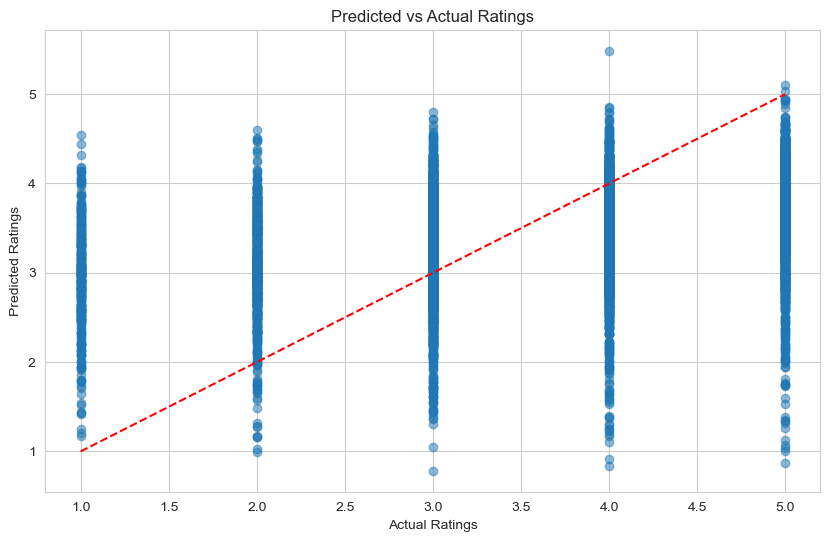

In [68]:

# Plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(actuals, preds, alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()

### **Conclusion**

1. The Neural Network model is the best performing model compared to the xgbregressor and catboostregressor as it generalizes better. and also is the only model that has a positive r2_score.
2. The models could improve significantly if it was trained on the entire dataet.
3. The NN model perfomrance can be improved by changing the activation function, optimizer, early stopping, etc.